In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))
import seaborn as sns
sns.set_theme(style="darkgrid")


In [2]:
import sys
# sys.path.append('../')
sys.path.append('../')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
sys.path.append('../sensor')
import QuadRotorPointMassModel
import QuadRotorPointMassCost
import QuadRotorPointMassConstraints
import QuadRotorSensor
from scipy.integrate import solve_ivp
from Scvx import Scvx

In [41]:
ix = 6
iu = 3
ih = 4
tf = 5
N = 50
delT = tf/N

In [42]:
# obstacle
r_safe = 0.3

c1 = np.array([1,4,0])
r1 = 0.3
H1_obs = np.diag([1/r1,1/r1,0])
H1_safe = np.diag([1/(r1+r_safe),1/(r1+r_safe),0])

c2 = np.array([1,2,0])
r2 = 0.5
H2_obs = np.diag([1/r2,1/r2,0])
H2_safe = np.diag([1/(r2+r_safe),1/(r2+r_safe),0])

c3 = np.array([-1,4,0])
r3 = 0.4
H3_obs = np.diag([1/r3,1/r3,0])
H3_safe = np.diag([1/(r3+r_safe),1/(r3+r_safe),0])

c4 = np.array([-1,2,0])
r4 = 0.3
H4_obs = np.diag([1/r4,1/r4,0])
H4_safe = np.diag([1/(r4+r_safe),1/(r4+r_safe),0])


c = []
c.append(c1)
c.append(c2)
c.append(c3)
c.append(c4)
H_obs = []
H_obs.append(H1_obs)
H_obs.append(H2_obs)
H_obs.append(H3_obs)
H_obs.append(H4_obs)
H_safe = []
H_safe.append(H1_safe)
H_safe.append(H2_safe)
H_safe.append(H3_safe)
H_safe.append(H4_safe)
r = []
r.append(r1)
r.append(r2)
r.append(r3)
r.append(r4)


assert len(c) == len(H_obs)
assert len(c) == len(H_safe)
num_obstacle = len(c)

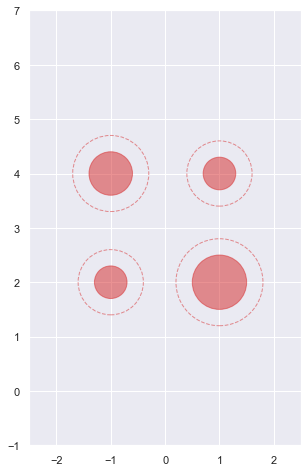

In [43]:
plt.figure(figsize=(5,8))
ax=plt.gca()
for ce,re in zip(c,r) :
    circle1 = plt.Circle((ce[0],ce[1]),re,color='tab:red',alpha=0.5,fill=True)
    circle2 = plt.Circle((ce[0],ce[1]),re+r_safe,linestyle='--',color='tab:red',alpha=0.5,fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
plt.axis([-2.5, 2.5, -1, 7])
plt.gca().set_aspect('equal', adjustable='box')

In [51]:
xi = np.array([-2,6,0,0,0,0])
xf = np.array([0,0,0,0,0,0])

myModel = QuadRotorPointMassModel.quadrotorpm('Hello',ix,iu,delT,linearization="analytic")
myCost = QuadRotorPointMassCost.quadrotorpm('Hello',ix,iu,N)
myConst = QuadRotorPointMassConstraints.quadrotorpm('Hello',ix,iu,ih,c,H_safe)
myObs = QuadRotorSensor.lidar('Hello',ix,iu)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf

u0 = np.zeros((N+1,iu))
u0[:,2] = 9.81

In [53]:
max_iter = 30
# i1 = Scvx('unicycle',N,max_iter,myModel,myCost,myConst,
#           type_discretization='zoh',w_c=1,w_vc=1e4,w_tr=1e-1)
i1 = Scvx('unicycle',N,max_iter,myModel,myCost,myConst,
          type_discretization='zoh',w_c=1,w_vc=1e4,w_tr=1e-1,tol_vc=1e-8)
x,u,xbar,ubar,total_num_iter = i1.update(x0,u0,xi,xf)

iteration   total_cost  cost        ||vc||     ||tr||       reduction   expected    w_tr        bounary
1           2463.4125   2459.8953   3.53e-10    35.2        -9.39       -9.39       0.100       1(1.94e-09)
2           2452.4312   2452.4096   1.13e-09    0.216       11          11          0.100       1(6.44e-09)
3           2451.1637   2451.1578   3.81e-10    0.0596      1.27        1.27        0.100       1(7.37e-10)
4           2451.0103   2451.0079   9.29e-10    0.0234      0.153       0.153       0.100       1(1.22e-09)
5           2451.0056   2451.0041   4.38e-10    0.0154      0.00466     0.00466     0.100       1(5.82e-10)
6           2451.0028   2451.0016   6.75e-10    0.0117      0.00281     0.00281     0.100       1(7.99e-10)
7           2451.0007   2450.9997   8.68e-10    0.00926     0.00215     0.00215     0.100       1(9.24e-10)
8           2450.9989   2450.9982   1.01e-09    0.0076      0.00172     0.00172     0.100       1(9.84e-10)
9           2450.9975   2450.996

In [54]:
list_time = delT * np.array([i for i in range(N+1)])
u_norm = np.linalg.norm(u,axis=1)
gimbal_angle = np.arccos(u[:,2] / u_norm)

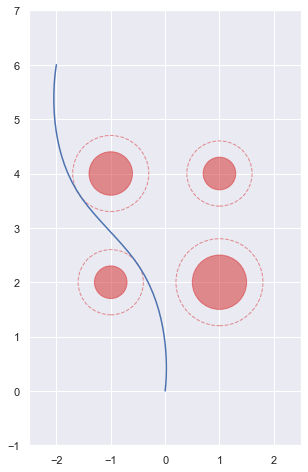

In [55]:
%matplotlib inline
plt.figure(figsize=(5,8))
ax=plt.gca()
for ce,re in zip(c,r) :
    circle1 = plt.Circle((ce[0],ce[1]),re,color='tab:red',alpha=0.5,fill=True)
    circle2 = plt.Circle((ce[0],ce[1]),re+r_safe,linestyle='--',color='tab:red',alpha=0.5,fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
plt.plot(xbar[:,0],xbar[:,1])
plt.axis([-2.5, 2.5, -1, 7])
plt.gca().set_aspect('equal', adjustable='box')

In [56]:
# %matplotlib qt
# def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
#     z = np.linspace(-height_z, height_z, 50)
#     theta = np.linspace(0, 2*np.pi, 50)
#     theta_grid, z_grid=np.meshgrid(theta, z)
#     x_grid = radius*np.cos(theta_grid) + center_x
#     y_grid = radius*np.sin(theta_grid) + center_y
#     return x_grid,y_grid,z_grid
# from mpl_toolkits.mplot3d import art3d
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X, east')
# ax.set_ylabel('Y, north')
# ax.set_zlabel('Z, up')
# ax.plot(x[:,0],x[:,1],x[:,2])
# ax.set_xlim([-3,3])
# ax.set_ylim([-1,7])
# ax.set_zlim([-1,1])

# Xc,Yc,Zc = data_for_cylinder_along_z(c[0][0],c[0][1],r1,1)
# ax.plot_surface(Xc, Yc, Zc, alpha=0.5)
# Xc,Yc,Zc = data_for_cylinder_along_z(c[1][0],c[1][1],r2,1)
# ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

(0.0, 20.0)

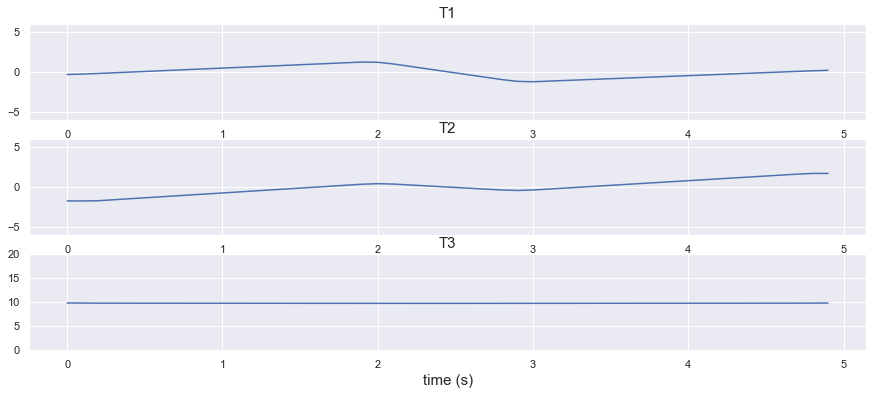

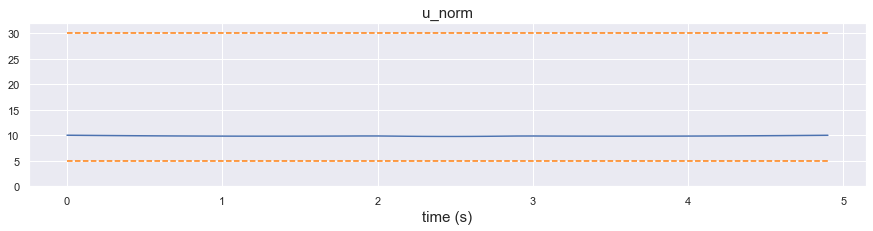

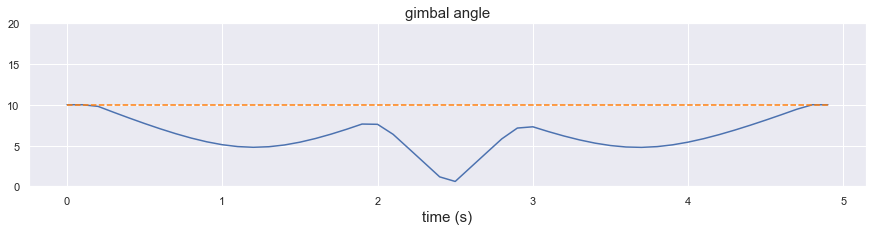

In [57]:
%matplotlib inline
fS = 15
plt.figure(figsize=(15,6))
plt.subplot(311)
plt.plot(list_time[:N],u[:N,0])
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-6,6])
plt.title('T1',fontsize=fS)
plt.subplot(312)
plt.plot(list_time[:N],u[:N,1])
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-6,6])
plt.title('T2',fontsize=fS)
plt.subplot(313)
plt.plot(list_time[:N],u[:N,2])
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([0,20])
plt.title('T3',fontsize=fS)


plt.figure(figsize=(15,3))
plt.plot(list_time[:N],u_norm[:N])
plt.plot(list_time[:N],list_time[:N]*0+myConst.T_max,'--',color='tab:orange')
plt.plot(list_time[:N],list_time[:N]*0+myConst.T_min,'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([0,32])
plt.title('u_norm',fontsize=fS)

plt.figure(figsize=(15,3))
plt.plot(list_time[:N],np.rad2deg(gimbal_angle[:N]))
plt.plot(list_time[:N],list_time[:N]*0+np.rad2deg(myConst.delta_max),'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.title('gimbal angle',fontsize=fS)
plt.ylim([0,np.rad2deg(myConst.delta_max)+10])

In [58]:
obs = myObs.state2obs(x,c,H_obs)

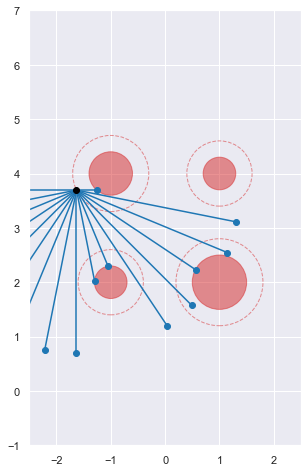

In [59]:
idx = 20
xp = x[idx]
lp = obs['point'][idx]
plt.figure(figsize=(5,8))
ax=plt.gca()
for ce,re in zip(c,r) :
    circle1 = plt.Circle((ce[0],ce[1]),re,color='tab:red',alpha=0.5,fill=True)
    circle2 = plt.Circle((ce[0],ce[1]),re+r_safe,linestyle='--',color='tab:red',alpha=0.5,fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
for ro in lp :
    plt.plot([xp[0],ro[0]],[xp[1],ro[1]],color='tab:blue')
    plt.plot(ro[0],ro[1],'o',color='tab:blue')
plt.plot(xp[0],xp[1],'o',color='black')
plt.axis([-2.5, 2.5, -1, 7])
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
import imageio
from utils import make_quadrotor_trajectory_fig
make_quadrotor_trajectory_fig(x,obs,c,H,r)